# Consistency training with supervision(監督による一貫性のあるトレーニング)

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/04/13<br>
**Last modified:** 2021/04/19<br>
**Description:** Training with consistency regularization for robustness against data distribution shifts.

深層学習モデルは、データが独立・同一分布（i.i.d.）している場合に、多くの画像認識タスクで優れた性能を発揮します。
しかし、ランダム入力データの微妙な分布の変化（ランダムなノイズ、コントラストの変化、ぼかしなど）による性能低下に悩まされます。
そこで、当然のことながら、次のような疑問が生じます。
なぜかなのかは[A Fourier Perspective on Model Robustness in Computer Vision](https://arxiv.org/pdf/1906.08988.pdf)で述べたとおりです。
深層学習モデルがそのような変化に対してロバストである理由はありません。標準的なモデルの学習手順（標準的な画像分類の学習ワークフローなど）では、
学習データとして与えられた以上のことを学習することは*できません*。

この例では、次のようにして、画像分類モデルを学習します。
次のようにして、モデルに*一貫性*を持たせます。

* 標準的な画像分類モデルを学習します。
* 同等以上のモデルを、ノイズの多いデータセット（[RandAugment](https://arxiv.org/abs/1909.13719)）を使って補強します。
* このためには、まず、データセットのきれいな画像に対して前のモデルの予測値を得ます。
* 次に、この予測値を用いて、予測値と一致するように2つ目のモデルを訓練します。これは、以下のワークフローと同じです。
[*Knowledge Distillation*](https://keras.io/examples/vision/knowledge_distillation/)のワークフローと同じですが学生モデルのサイズは同等以上なので、このプロセスは***自己訓練***のようにも呼ばれます。

このような全体的なトレーニングのワークフローは、以下のような作品にルーツがあります。
[FixMatch](https://arxiv.org/abs/2001.07685)や[Unsupervised Data Augmentation for Consistency Training](https://arxiv.org/abs/1904.12848)、
[Noisy Student Training](https://arxiv.org/abs/1911.04252)などがあります。
この学習プロセスは、ノイズの多い画像だけでなく、きれいな画像に対しても一貫した予測を行うようにモデルを促すので
*一貫性のある学習*、または*一貫性正則化を用いた学習*と呼ばれています。
この例は、一般的なノイズに対するモデルのロバスト性を高めるためのものですが弱い教師付き学習を行うためのテンプレートにもなります。

この例では、TensorFlow 2.4以上、およびTensorFlow HubとTensorFlow Modelsが必要です。
これらは次のコマンドでインストールできます。

In [1]:
!pip install -q tf-models-official tensorflow-addons

## インポートとセットアップ

In [2]:
from official.vision.image_classification.augment import RandAugment
from tensorflow.keras import layers

import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

tf.random.set_seed(42)

## ハイパーパラメータの定義

In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5

CROP_TO = 72
RESIZE_TO = 96

## CIFAR-10データセットの読み込み

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

val_samples = 49500
new_train_x, new_y_train = x_train[: val_samples + 1], y_train[: val_samples + L1]
val_x, val_y = x_train[val_samples:], y_train[val_samples:]

170508288/170498071 [==============================] - 27s 0us/step


## TensorFlowの`Dataset`オブジェクトの作成

In [5]:
# RandAugmentオブジェクトを2層の拡張変換と9の強度で初期化
augmenter = RandAugment(num_layers=2, magnitude=9)

教師モデルの学習には，2種類の幾何学的な拡張変換（ランダムな水平反転、ランダムなクロップ）のみを使用します。
ランダムな水平反転とランダムなクロップです。

In [6]:
def preprocess_train(image, label, noisy=True):
    image = tf.image.random_flip_left_right(image)
    # We first resize the original image to a larger dimension
    # and then we take random crops from it.
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.image.random_crop(image, [CROP_TO, CROP_TO, 3])
    if noisy:
        image = augmenter.distort(image)
    return image, label


def preprocess_test(image, label):
    image = tf.image.resize(image, [CROP_TO, CROP_TO])
    return image, label


train_ds = tf.data.Dataset.from_tensor_slices((new_train_x, new_y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

2021-11-05 11:31:30.198610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:31:30.199039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:31:30.218425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:31:30.218866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:31:30.219481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

`train_clean_ds`と`train_noisy_ds`が同じ種を使ってシャッフルされていることを確認します。
これは、学生モデルのトレーニングに役立ちます。

In [7]:
# このデータセットは、最初のモデルの学習に使用されます
train_clean_ds = (
    train_ds.shuffle(BATCH_SIZE * 10, seed=42)
    .map(lambda x, y: (preprocess_train(x, y, noisy=False)), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# RandAugmentを使用するために、Datasetオブジェクトを準備します。
train_noisy_ds = (
    train_ds.shuffle(BATCH_SIZE * 10, seed=42)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# このデータセットは、2つ目のモデルの学習に使用されます。
consistency_training_ds = tf.data.Dataset.zip((train_clean_ds, train_noisy_ds))

## データセットの可視化

2021-11-05 11:31:40.147490: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 152067072 exceeds 10% of free system memory.
2021-11-05 11:31:40.194945: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-05 11:31:40.360810: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 152067072 exceeds 10% of free system memory.


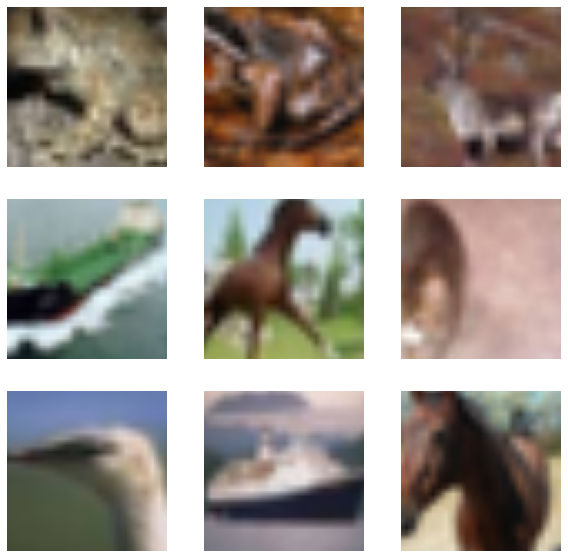

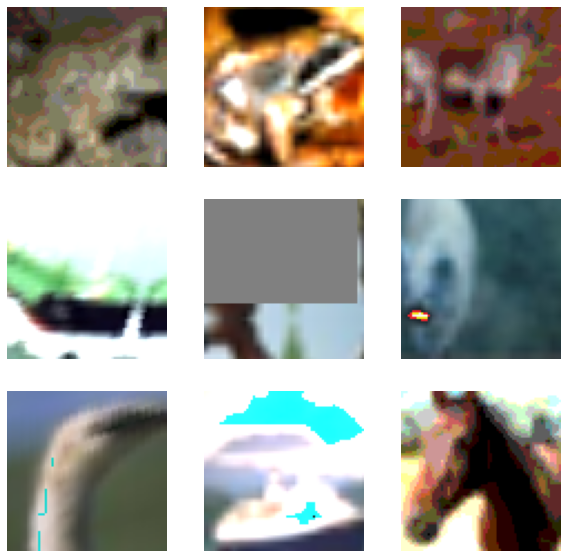

In [8]:
sample_images, sample_labels = next(iter(train_clean_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

sample_images, sample_labels = next(iter(train_noisy_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

## モデル設定の効用関数の定義

ここで、我々のモデル構築ユーティリティーを定義します。我々のモデルは、[ResNet50V2 architecture](https://arxiv.org/abs/1603.05027)に基づいています。

In [9]:
def get_training_model(num_classes=10):
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None, include_top=False, input_shape=(CROP_TO, CROP_TO, 3),
    )
    model = tf.keras.Sequential(
        [
            layers.Input((CROP_TO, CROP_TO, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
            layers.GlobalAveragePooling2D(),
            layers.Dense(num_classes),
        ]
    )
    return model

教師ネットワークの再現性を高めるために，初期のランダムな重みをシリアライズします。

In [10]:
initial_teacher_model = get_training_model()
initial_teacher_model.save_weights("initial_teacher_model.h5")

## 教師モデルの学習

Noisy Student Trainingで述べたように、教師モデルが*幾何学的アンサンブル*で学習され、生徒モデルがそれを模倣するように強制された場合、より良い結果が得られます。
オリジナルの研究では、[Stochastic Depth](https://arxiv.org/abs/1603.09382)と[Dropout](https://jmlr.org/papers/v15/srivastava14a.html)を使ってアンサンブルの部分を取り入れています。
この例では、[Stochastic Weight Averaging](https://arxiv.org/abs/1803.05407)(SWA)を使います。これも幾何学的アンサンブルに似ています。

In [11]:
# コールバックを定義
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

# tf-hubからSWAを初期化
SWA = tfa.optimizers.SWA

# 教師モデルのコンパイルとトレーニング
teacher_model = get_training_model()
teacher_model.load_weights("initial_teacher_model.h5")
teacher_model.compile(
    # オプティマイザーをSWAで包んでいることに注目してください
    optimizer=SWA(tf.keras.optimizers.Adam()),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
history = teacher_model.fit(
    train_clean_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping],
)

# テストセットで教師モデルを評価
_, acc = teacher_model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {acc*100}%")

2021-11-05 11:31:50.646649: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 152067072 exceeds 10% of free system memory.


Epoch 1/5


2021-11-05 11:32:04.256174: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2021-11-05 11:32:04.711587: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


387/387 [==============================] - 72s 144ms/step - loss: 1.5559 - accuracy: 0.4363 - val_loss: 1.4592 - val_accuracy: 0.5060
Epoch 2/5
387/387 [==============================] - 54s 138ms/step - loss: 1.1970 - accuracy: 0.5717 - val_loss: 1.3520 - val_accuracy: 0.5660
Epoch 3/5
387/387 [==============================] - 54s 139ms/step - loss: 0.9974 - accuracy: 0.6497 - val_loss: 1.1717 - val_accuracy: 0.6520
Epoch 4/5
387/387 [==============================] - 56s 144ms/step - loss: 0.8772 - accuracy: 0.6941 - val_loss: 1.0624 - val_accuracy: 0.6520
Epoch 5/5
387/387 [==============================] - 56s 145ms/step - loss: 0.7741 - accuracy: 0.7303 - val_loss: 1.2117 - val_accuracy: 0.6100
Test accuracy: 61.52999997138977%


## セルフトレーニングユーティリティーの定義

この部分では、[this Keras Example](https://keras.io/examples/vision/knowledge_distillation/)から`Distiller`クラスを借ります。

In [12]:
# コードの大部分は以下から引用されています
# https://keras.io/examples/vision/knowledge_distillation/
class SelfTrainer(tf.keras.Model):
    def __init__(self, student, teacher):
        super(SelfTrainer, self).__init__()
        self.student = student
        self.teacher = teacher

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, temperature=3,
    ):
        super(SelfTrainer, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature

    def train_step(self, data):
        # 今回のデータセットは、2つの独立したデータセットをZIP形式にしたものなので、
        # 最初に解析した後、次のように画像とラベルを分離します。
        clean_ds, noisy_ds = data
        clean_images, _ = clean_ds
        noisy_images, y = noisy_ds

        # 教師のフォワードパス
        teacher_predictions = self.teacher(clean_images, training=False)

        with tf.GradientTape() as tape:
            # 学生のフォワードパス
            student_predictions = self.student(noisy_images, training=True)

            # 損失の計算
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            total_loss = (student_loss + distillation_loss) / 2

        # グラデーションの計算
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # ウェイトの更新
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # compile()で設定したメトリクスの更新
        self.compiled_metrics.update_state(
            y, tf.nn.softmax(student_predictions, axis=1)
        )

        # パフォーマンスのディクショナリーを返す
        results = {m.name: m.result() for m in self.metrics}
        results.update({"total_loss": total_loss})
        return results

    def test_step(self, data):
        # 推論の際には、画像とラベルからなるデータセットを渡すだけです。
        x, y = data

        # 予測値の算出
        y_prediction = self.student(x, training=False)

        # メトリクスの更新
        self.compiled_metrics.update_state(y, tf.nn.softmax(y_prediction, axis=1))

        # パフォーマンスのディクショナリーを返す
        results = {m.name: m.result() for m in self.metrics}
        return results

この実装の唯一の違いは、損失の計算方法です。
**蒸留損失と学生損失の重み付けを変える代わりに、Noisy Student Training**後の平均値を採用しています。

## Train the student model

In [13]:
# コールバックを定義します。
# トレーニングを安定させるために、より大きな減衰係数を使用しています。
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=3, factor=0.5, monitor="val_accuracy"
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor="val_accuracy"
)

# 学生モデルのコンパイルとトレーニング
self_trainer = SelfTrainer(student=get_training_model(), teacher=teacher_model)
self_trainer.compile(
    # ここではSWAを使用していないことに注意してください。
    optimizer="adam",
    metrics=["accuracy"],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    temperature=10,
)
history = self_trainer.fit(
    consistency_training_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping],
)

# 学生モデルを評価する。
acc = self_trainer.evaluate(test_ds, verbose=0)
print(f"Test accuracy from student model: {acc * 100}%")

Epoch 1/5
387/387 [==============================] - 74s 183ms/step - accuracy: 0.2559 - total_loss: 1.0761 - val_accuracy: 0.3760
Epoch 2/5
387/387 [==============================] - 70s 181ms/step - accuracy: 0.3402 - total_loss: 0.9633 - val_accuracy: 0.1780
Epoch 3/5
387/387 [==============================] - 69s 177ms/step - accuracy: 0.3935 - total_loss: 0.8984 - val_accuracy: 0.4680
Epoch 4/5
387/387 [==============================] - 69s 177ms/step - accuracy: 0.4260 - total_loss: 0.8592 - val_accuracy: 0.5920
Epoch 5/5
387/387 [==============================] - 67s 173ms/step - accuracy: 0.4511 - total_loss: 0.8294 - val_accuracy: 0.5440
Test accuracy from student model: 54.55999970436096%


## モデルのロバスト性の評価

ビジョンモデルのロバスト性を評価する標準的なベンチマークは、ImageNet-CやCIFAR-10-Cのような破損したデータセットでのパフォーマンスを記録することです。
[Benchmarking Neural Network Robustness to Common Corruptions and Perturbations](https://arxiv.org/abs/1903.12261)で提案されたものです。
この例では、以下のデータセットを使用します。
CIFAR-10-Cデータセットを使用します。CIFAR-10-Cデータセットには、5つの異なる深刻度レベルで19種類の破損があります。
ここではこのデータセットに対するモデルのロバスト性を評価するために、以下のようにします。

* 事前学習したモデルを最高レベルの深刻度で実行し、トップ1の精度を得る。
* 平均トップ1精度を算出する。

この例では、これらのステップを踏むことはありません。
これが、今回5回のエポックのみでモデルをトレーニングした理由です。
これは、[このリポジトリ](https://github.com/sayakpaul/Consistency-Training-with-Supervision)では
本格的な学習実験と、前述の評価を示しています。
下図は、その評価の概要を示しています。

![](https://i.ibb.co/HBJkM9R/image.png)

**平均Top-1**の結果はCIFAR-10-Cデータセット、**テストTop-1**の結果はCIFAR-10テストセットの結果です。
一貫性のある学習は、モデルのロバスト性を向上させるだけでなく、
標準的なテストのパフォーマンスを向上させるためにも一貫性学習が有利であることは明らかです。